# A) Carregar llibreries

In [1]:
##A)Carregar llibreries
import pandas as pd ###py -m pip install pandas
import numpy as np ###py -m pip install numypy

from sklearn.decomposition import PCA ###py -m pip install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from yellowbrick.cluster import KElbowVisualizer ##py -m pip install yellowbrick
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns ##py -m pip install seaborn

import matplotlib.pyplot as plt ##py -m pip install matplotlib

# B) Carregar dataset

In [203]:
##B)Carregar el dataset
df = pd.read_csv('SpotifyFeatures.csv')
#print(f"Mostra: {df.head()}") #Mostra 5 rows
print(f"Info: {df.info()}") #Mostra el tipus de columns: df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

# C) Preparar dades

In [204]:
##C)Preparar dades
#1) Tractar duplicats
#Quantitat duplicats
print("Quantitat de dupplicats:", df.duplicated(subset="track_id", keep="first").sum())

#Treure duplicats (files)
df.drop_duplicates(subset="track_id", keep="first", inplace=True)
print("Quantitat de dupplicats després:", df.duplicated(subset="track_id", keep="first").sum())
print("New shape sense duplicats:", df.shape)

#Treure duplicats (files)
df.drop("genre", axis=1, inplace=True)
print("New shape sense genre:", df.shape)

Quantitat de dupplicats: 55951
Quantitat de dupplicats després: 0
New shape sense duplicats: (176774, 18)
New shape sense genre: (176774, 17)


In [205]:
#2) Corretgir valors errònis (impossibles)
#Comprovar valors de key, mode i time_signature
#print("Key values:", df['key'].value_counts())
#print("Mode values:", df["mode"].value_counts())
#print("Time_signature values:", df["time_signature"].value_counts())
#print("Genre values::", df["genre"].value_counts())

#Eliminar key: "0/4" (impossible)
print("Quantitat de '0/4'abans:", (df["time_signature"] == "0/4").sum()) #Quantitat key: "0/4"
df = df[df["time_signature"] != "0/4"]
print("Quantitat de '0/4' després:", (df["time_signature"] == "0/4").sum())
print("New shape sense '0/4':", df.shape)

#Eliminar NaN
print("Quantitat de Nan abans:", df.isna().sum().sum()) #Quantitat Nan en tot df
#print("NaN per features:", df.isna().sum())
df.dropna(axis=0, inplace=True) #
print("Quantitat de Nan després:", df.isna().sum().sum())
print("New shape sense Nan:", df.shape)

Quantitat de '0/4'abans: 6
Quantitat de '0/4' després: 0
New shape sense '0/4': (176768, 17)
Quantitat de Nan abans: 1
Quantitat de Nan després: 0
New shape sense Nan: (176767, 17)


In [206]:
#3) Eliminar columnes innecesàries
#Drop olumnes: 'artist_name','track_name','track_id 
df.drop(['artist_name','track_name','track_id'], axis=1, inplace=True) #Elimina les columnes modificant df og
print(f"Nova shape sense artist_name, track_name, track_id: {df.shape}") #Mostra rowsxcolumns

Nova shape sense artist_name, track_name, track_id: (176767, 14)


In [207]:
#4)Codificar columnes no numèriques
#Diccionaris codificació valors únics
"""
mode_dict = {'Major' : 1, 'Minor' : 0}
key_dict = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}
time_signature_dict = {'1/4' : 1, '3/4' : 3, '4/4' :4, "5/4": 5}

#Codificar columna key 
df["key"] = df["key"].map(key_dict)

#Codificar columna mode 
df["mode"] = df["mode"].map(mode_dict)

#Codificar columna time_signature
df["time_signature"] = df["time_signature"].map(time_signature_dict)
"""

#METODE2
freq = df["key"].value_counts(normalize=True)
df["key"] = df["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df["mode"] = df["mode"].map(freq)
#Codificar columna time_signature
freq = df["time_signature"].value_counts(normalize=True)
df["time_signature"] = df["time_signature"].map(freq)



# D) Establir model

In [208]:
#1) Copiar df
data = df.copy()
print("Info:", data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 176767 entries, 0 to 232724
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        176767 non-null  int64  
 1   acousticness      176767 non-null  float64
 2   danceability      176767 non-null  float64
 3   duration_ms       176767 non-null  int64  
 4   energy            176767 non-null  float64
 5   instrumentalness  176767 non-null  float64
 6   key               176767 non-null  float64
 7   liveness          176767 non-null  float64
 8   loudness          176767 non-null  float64
 9   mode              176767 non-null  float64
 10  speechiness       176767 non-null  float64
 11  tempo             176767 non-null  float64
 12  time_signature    176767 non-null  float64
 13  valence           176767 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 20.2 MB
Info: None


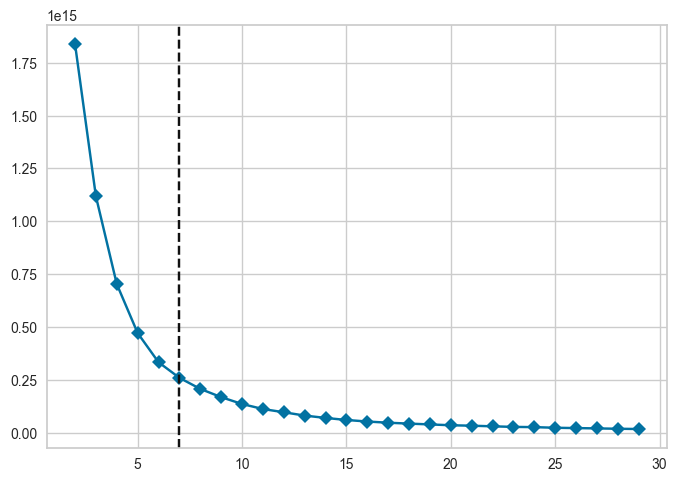

In [209]:
#2) Calcular k millor
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(data)       
#visualizer.show()        
k = visualizer.elbow_value_ #millor k

In [210]:
#3) Fer amb Scaler (mateix rang totes feature)
scaler = StandardScaler()
data_scal = scaler.fit_transform(data)
#data_scal = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)

In [211]:
#4) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
pred = kmeans.fit_predict(data_scal)
#data_scal["cluster"] = pred

# E) Visualitzar predicció amb PCA

In [212]:
#1) Reduir components a 2 amb PCA
pca = PCA(n_components=2)
data_scal_2 = pca.fit_transform(data_scal)

#Crear dataframe per visualitzar 
pca_2 = pd.DataFrame(data=data_scal_2, columns=['Component 1', 'Component 2'])
pca_2["Cluster"] = pred

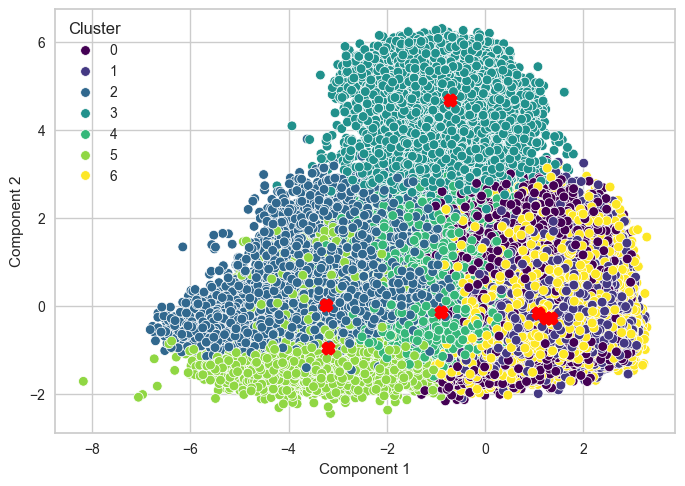

23098.34808221117 2.0561740796815817


In [213]:
#2) Scatterplot (en jupyter)
#Plot les dades
center = pca.transform(kmeans.cluster_centers_)
sns.scatterplot(data=pca_2, x='Component 1', y='Component 2', hue='Cluster', palette='viridis')
plt.scatter([c[0] for c in center],[c[1] for c in center], marker='X', linewidths=3, color='red')
plt.show()

#Evaluat: higher better - lower better
print(calinski_harabasz_score(data_scal, kmeans.labels_), davies_bouldin_score(data_scal, kmeans.labels_))

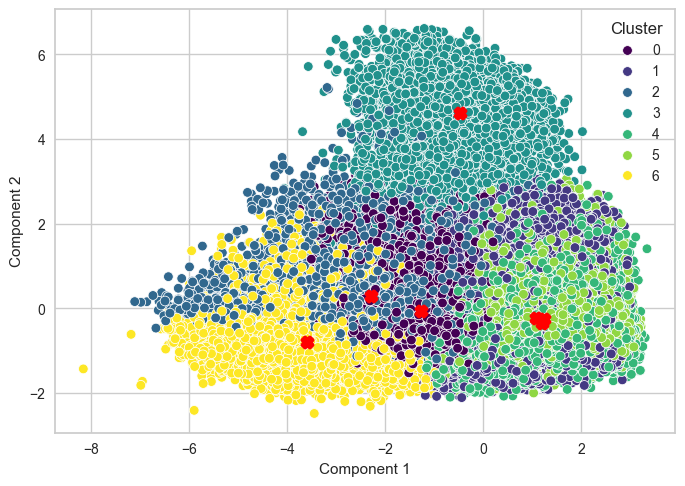

22037.593923597928 2.065873655775511


In [202]:
#2) Scatterplot (en jupyter)
#Plot les dades
center = pca.transform(kmeans.cluster_centers_)
sns.scatterplot(data=pca_2, x='Component 1', y='Component 2', hue='Cluster', palette='viridis')
plt.scatter([c[0] for c in center],[c[1] for c in center], marker='X', linewidths=3, color='red')
plt.show()

#Evaluat: higher better - lower better
print(calinski_harabasz_score(data_scal, kmeans.labels_), davies_bouldin_score(data_scal, kmeans.labels_))